In [63]:
from pycocotools.coco import COCO
import supervision as sv
from PIL import Image, ImageDraw
import os
import numpy as np

In [64]:
from datasets import load_dataset

train_path = "/APP/florence-2/data/city-road/train-00000.parquet"
val_path = "/APP/florence-2/data/city-road/val-00000.parquet"
dataset = load_dataset("parquet", data_files={'train': train_path, 'val': val_path})

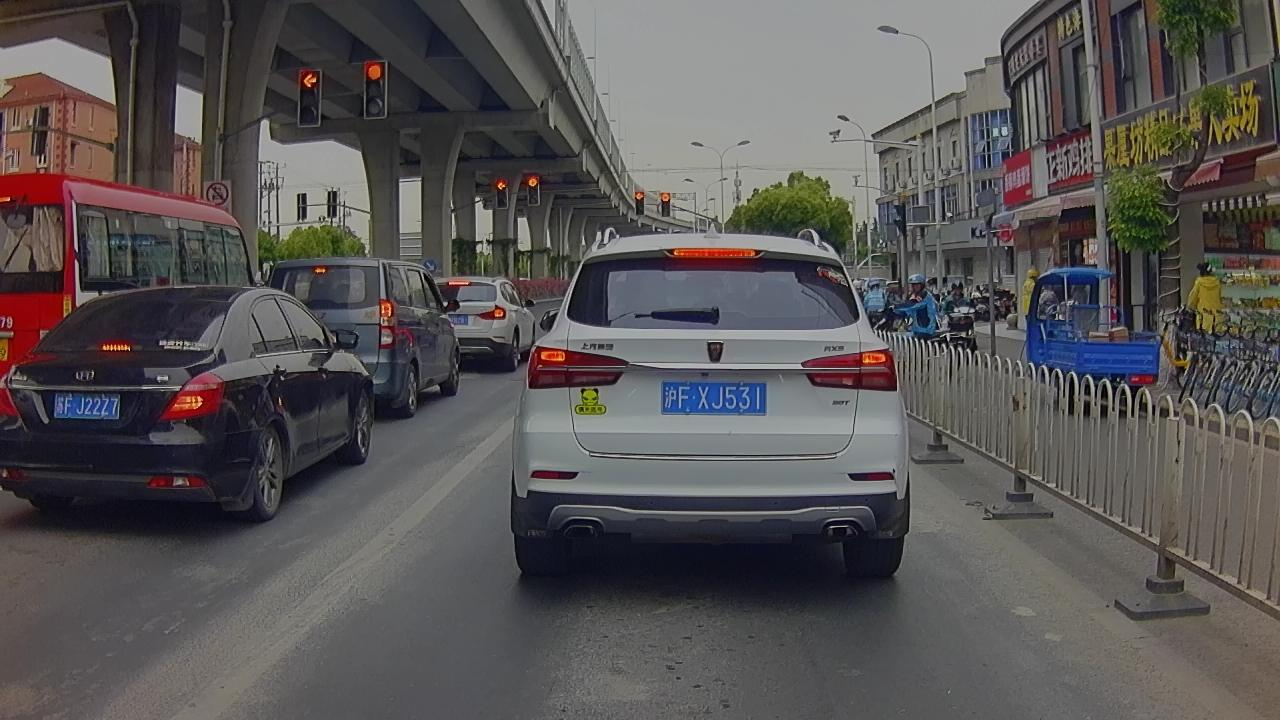

In [65]:
index = 98
display(dataset['train'][index]['image'])

In [66]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="0" 
import torch
from transformers import AutoModelForCausalLM, AutoProcessor

CHECKPOINT = "/APP/florence-2/task_od/outputs_od/od_city_model_checkpoints/epoch_5"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

In [67]:
import supervision as sv
from PIL import Image

def run_inference(image: Image, task: str, text: str = ""):
    prompt = task + text
    
    if image.mode != "RGB":
        image = image.convert("RGB")
        
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(generated_text, task=task, image_size=image.size)

response: {'<OD>': {'bboxes': [[0.6399999856948853, 283.32000732421875, 373.1199951171875, 520.9200439453125], [260.47998046875, 255.9600067138672, 458.8800048828125, 416.52001953125], [423.03997802734375, 274.6800231933594, 534.3999633789062, 369.7200012207031], [508.79998779296875, 230.760009765625, 909.4400024414062, 576.3600463867188], [891.5199584960938, 271.8000183105469, 977.2799682617188, 381.2400207519531], [859.5199584960938, 276.8399963378906, 905.5999755859375, 330.84002685546875], [946.5599975585938, 279.7200012207031, 973.4400024414062, 320.760009765625], [969.5999755859375, 281.8800048828125, 1005.4400024414062, 320.0400085449219], [1019.5199584960938, 266.0400085449219, 1161.5999755859375, 414.3600158691406], [1188.47998046875, 261.0, 1220.47998046875, 363.96002197265625]], 'labels': ['car', 'car', 'car', 'car', 'cyclist', 'cyclist', 'cyclist', 'cyclist', 'cyclist', 'person']}}
(1280, 720)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


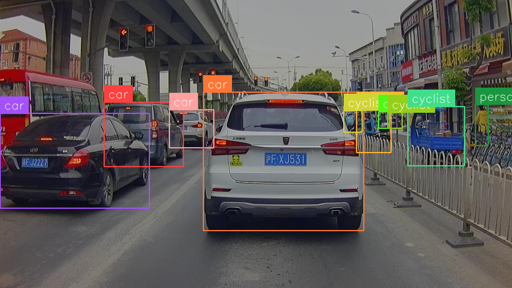

In [68]:
index = 98
image = dataset['train'][index]['image']
image_od = image.copy()
task = "<OD>"
response = run_inference(image=image, task=task, text='')
print("response:",response)
print(image.size)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX, thickness=2)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX, text_scale=1)

image_od = bounding_box_annotator.annotate(image_od, detections)
image_od = label_annotator.annotate(image_od, detections)
image_od.thumbnail((512, 288))
image_od

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


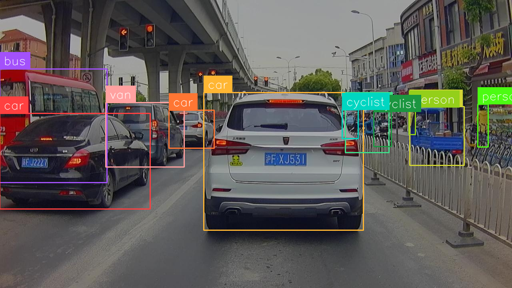

In [69]:
def xywh2xyxy(bbox):
    """
    change bbox to coco format
    :param bbox: [x, y, w, h]
    :return: [x1, y1, x2, y2]
    """
    return [
        bbox[0],
        bbox[1],
        bbox[2] + bbox[0],
        bbox[3] + bbox[1],
    ]

def build_gt(index=0):
    example = dataset['train'][index]
    image = example['image']
    objects = example['objects']
    gt_bboxes = objects['bbox']
    gt_bboxes = [xywh2xyxy(gt_bbox) for gt_bbox in gt_bboxes]

    gt_labels = objects['category']

    class_names = {
        0: 'car',
        1: 'truck',
        2: 'person',
        3: 'bicycle',
        4: 'cyclist',
        5: 'van',
        6: 'tricycle',
        7: 'bus'
    }  

    gt_labels = [class_names[gt_label] for gt_label in gt_labels] 

    response = {'<OD>': {'bboxes': gt_bboxes, 'labels': gt_labels}}
    return response

response = build_gt(index=98)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX, thickness=2)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX, text_scale=1)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((512, 288))
image